#### 과제 가이드라인
- 분석 자료 : 최근 3개월간 신규 구매 데이터 일부

- 분석 필요 내용

  1. 구매 소요 시간 분석
     1-1. 가입일로부터 구매일까지 전환된 소요시간 분석
         - 최근 3개월 전체 분석 / 각 월 별 분석
         - 분기 경향 / 월 별 변동사항 확인 -> 트렌드 분석
            ex. 가입 1일 이내 전환 유저 : 10% -> 15% 상승 성과
 **2. 구매 상품 트렌드 분석**
 
     2-1. 유저당 주문 수량 분석
         - 최근 3개월 전체 분석 / 각 월 별 분석
         - 분기 경향 / 월 별 변동사항 확인 -> 트렌드 분석
     2-2. 주문 아이템 분석
         - 브랜드 별 선호도, 아이템 카테고리별 선호도 분석
         - 신규 유저들의 구매 트렌드 파악
  3. 분석 내용 토대로 인사이트 도출
     3-1. 분석 내용 도식화
         - 1~2의 분석 내용 종합 및 도식화 (표 또는 그래프)
         - 유사성을 갖는 결과에 대하여 그룹화
     3-2. 인사이트 도출
         - 해당 결과를 통해 나타나는 사항 정리
         - 인사이트 도출 혹은 새로운 제안사항 전달 (없을 시 진행하지 않아도 무방)

- 분석 참고 사항

  1. 용어 및 칼럼 설명
     brandnm : 아이템 브랜드명
     goodsnm : 아이템 명
     USER : 개별 유저 식별 값
     reg_date : 개별 유저 가입일
     order_date : 아이템 주문일
     p_type : 주문 상품 종류
             7days (7일권) / 4days (4일권)
     sub_type : 주문 상품 카테고리 
               BA – 가방 / O – 아우터 / D – 드레스 / T – 상의 / B – 하의 / TB – 투피스 
     app_yn : 어플리케이션 사용 여부
              Y – 어플리케이션 사용 / (공백) – 어플리케이션 미사용

- EDA Metric
    - demographic
    

#### 모듈 import

In [150]:
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style(style="white")
plt.rc('font', family='Malgun Gothic') 
plt.rcParams['figure.figsize'] = (10, 7)
plt.rcParams['axes.unicode_minus'] = False    # minus

from matplotlib_venn import venn3, venn3_circles
from matplotlib_venn import venn2, venn2_circles

# interactive
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import warnings
warnings.filterwarnings('ignore')

# encoding
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# modeling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

#### Data import

##### 과제 data

In [361]:
# 과제 data
closet = pd.read_excel('../week3/클로젯셰어_과제DB 대체 자료.xlsx',)
df = closet.copy()
# col > lower
df.columns=list(map(lambda x: x.lower(),df.columns))

In [362]:
df = df.sort_values(['order_date','user']).reset_index(drop=True)

In [363]:
# 가입 정보 관련 날짜 변수 추가 
df['reg_date']=pd.to_datetime(df['reg_date'])
df['reg_year']=df['reg_date'].dt.strftime('%Y')
df['reg_month']=df['reg_date'].dt.strftime('%m')
df['reg_yearmonth']=df['reg_date'].dt.strftime('%Y-%m')
df['order_month']=df['order_date'].dt.month
df['order_week']=df['order_date'].dt.week
df['order_dayofweek']=df['order_date'].dt.dayofweek
# date continuous변환
df['order_date']=pd.to_datetime(df['order_date']).dt.date
df['reg_date']=pd.to_datetime(df['reg_date']).dt.date

In [364]:
# 2021 top 10 list
luxury_list=['GUCCI','Louis Vuitton','Cartier','Chanel','Hermes','Ferrari','Rolex','Dior','Christian Dior','COACH','Estee Lauder','Tiffany & Co.',
'Guerlain','Burberry','Prada','Lancôme','Omega','Clarins','Bulgari','Moncler','Saint Laurent','SK-II','McLaren','TAG Heuer','Givenchy','Lamborghini','Armani','Bottega Veneta','Rolls- Royce',
'Bentley','Aston Martin','Loewe','Maserati','Van Cleef & Arpels','Valentino','Salvatore Ferragamo','Shiseido','Sulwhasoo','Tissot','Versace','Bobbi Brown','Montblanc','Tom Ford','Longines','Cle de Peau Beaute','Jaeger-LeCoultre',
'Celine','Dolce & Gabbana','Miu Miu','Fendi']
# brandnm luxury 
df['brandnm_luxury']=np.where(df['brandnm'].isin(luxury_list), 1,0)
df.head()

,brandnm,goodsnm,user,reg_date,order_date,p_type,sub_type,app_yn,reg_year,reg_month,reg_yearmonth,order_month,order_week,order_dayofweek,brandnm_luxury
0,Chanel,pocket graphics pattern zipup-jumper navy,a1112031,2020-08-15,2021-01-01,7days,O,NaN,2020,08,2020-08,1,53,4,1
1,El estilo de Claire,beads stud velvet jacket black,a196681,2020-04-17,2021-01-01,4days,O,Y,2020,04,2020-04,1,53,4,0
2,Baum Und Pferdgarten,geometric pattern A-Line dress purple,a196681,2020-04-17,2021-01-01,4days,D,Y,2020,04,2020-04,1,53,4,0
3,BCBG,pleats basic pattern H-Line dress deeppink,a196681,2020-04-17,2021-01-01,4days,D,Y,2020,04,2020-04,1,53,4,0
4,Balmain,double button long coat white,a1140621,2020-12-31,2021-01-02,7days,O,NaN,2020,12,2020-12,1,53,5,0


##### 외부 data

In [28]:
# 크롤링 data 가격정보
price = pd.read_excel('../week3/tag_price_df.xlsx')
# remove space
price.columns=list(map(lambda x: x.replace(' ',''),price.columns))

### 데이터 개요

In [184]:
df.head(5)

,brandnm,goodsnm,user,reg_date,order_date,p_type,sub_type,app_yn,reg_year,reg_month,reg_yearmonth,order_dayofweek
0,Chanel,pocket graphics pattern zipup-jumper navy,a1112031,2020-08-15,2021-01-01,7days,O,NaN,2020,08,2020-08,4
1,El estilo de Claire,beads stud velvet jacket black,a196681,2020-04-17,2021-01-01,4days,O,Y,2020,04,2020-04,4
2,Baum Und Pferdgarten,geometric pattern A-Line dress purple,a196681,2020-04-17,2021-01-01,4days,D,Y,2020,04,2020-04,4
3,BCBG,pleats basic pattern H-Line dress deeppink,a196681,2020-04-17,2021-01-01,4days,D,Y,2020,04,2020-04,4
4,Balmain,double button long coat white,a1140621,2020-12-31,2021-01-02,7days,O,NaN,2020,12,2020-12,5


In [365]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1471 entries, 0 to 1470
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   brandnm          1442 non-null   object
 1   goodsnm          1471 non-null   object
 2   user             1471 non-null   object
 3   reg_date         1466 non-null   object
 4   order_date       1471 non-null   object
 5   p_type           1471 non-null   object
 6   sub_type         1471 non-null   object
 7   app_yn           1295 non-null   object
 8   reg_year         1466 non-null   object
 9   reg_month        1466 non-null   object
 10  reg_yearmonth    1466 non-null   object
 11  order_month      1471 non-null   int64 
 12  order_week       1471 non-null   int64 
 13  order_dayofweek  1471 non-null   int64 
 14  brandnm_luxury   1471 non-null   int32 
dtypes: int32(1), int64(3), object(11)
memory usage: 166.8+ KB


In [108]:
df.describe().T

,count,unique,top,freq,first,last
brandnm,1442,245,Gucci,232,NaT,NaT
goodsnm,1471,979,chevron quilted cross bag black,23,NaT,NaT
user,1471,1234,a1149461,11,NaT,NaT
reg_date,1466,368,2021-03-16 00:00:00,44,2017-06-24,2021-03-31
order_date,1471,90,2021-03-24 00:00:00,47,2021-01-01,2021-03-31
p_type,1471,2,4days,894,NaT,NaT
sub_type,1471,6,BA,692,NaT,NaT
app_yn,1295,1,Y,1295,NaT,NaT


In [30]:
price.tail() # 가격 쉼표 제거 필요, tag # 제거

,brand2,product2,tag1,tag2,tag3,tag4,4일가격,7일가격
367,Prada,color strap shoulder bag navy,#오피스,NaN,NaN,NaN,"39,000원\n7일","49,000원"
368,Chloe,drew bag beige,#오피스,#위켄드,NaN,NaN,"39,000원\n7일","49,000원"
369,Maison Margiela,Bucket black bag,#일상,NaN,NaN,NaN,"39,000원\n7일","49,000원"
370,Dior,croisiere patent lady bag navy,#위켄드,NaN,NaN,NaN,"49,000원\n7일","59,000원"
371,Gucci,vintage web GG two way bag brown,#오피스,NaN,NaN,NaN,"49,000원\n7일","59,000원"


In [77]:
price['7일가격'].unique()

array(['59,000원', '44,000원', '49,000원', nan, '69,000원', ']'], dtype=object)

In [65]:
price.describe().T

,count,unique,top,freq
brand2,372,25,Gucci,118
product2,372,137,chevron quilted cross bag black,8
tag1,334,6,#오피스,186
tag2,166,6,#위켄드,76
tag3,24,3,#파티,10
tag4,4,1,#포멀이벤트,4
4일가격,368,4,"49,000원\n7일",192
7일가격,368,5,"59,000원",191


#### 데이터 개요 정리

In [45]:
print('브랜드 수:', df.brandnm.nunique(),'\n')
print('유저 수:', df.user.nunique(),'\n')
print('구매 타입 수:', df.p_type.nunique())
print('구매 타입 수:', df.p_type.unique(),'\n')
print('서브 타입 수:', df.sub_type.nunique())
print('서브 타입 수:', df.sub_type.unique(),'\n')
print('가입 정보 기간:', df.reg_date.min() ,"~", df.reg_date.max())
print('구매 정보 기간:', df.order_date.min() ,"~", df.order_date.max())

브랜드 수: 245 

유저 수: 1234 

구매 타입 수: 2
구매 타입 수: ['7days' '4days'] 

서브 타입 수: 6
서브 타입 수: ['BA' 'O' 'B' 'T' 'D' 'TP'] 

가입 정보 기간: 2017-06-24 00:00:00 ~ 2021-03-31 00:00:00
구매 정보 기간: 2021-01-01 00:00:00 ~ 2021-03-31 00:00:00


In [58]:
df.groupby('user')['order_date'].count().sort_values()

user
a1146892     1
a1148775     1
a1148769     1
a1148768     1
a1148750     1
            ..
a189404      7
a1143701     7
a1142677     9
a1149583    10
a1149461    11
Name: order_date, Length: 1234, dtype: int64

In [61]:
# 1회 주문 건수 11회인 유저 : reg date과 order date 차이 2일 > 신규 유저 이벤트가 아닐까?
df.query('user=="a1149461"')

,brandnm,goodsnm,user,reg_date,order_date,p_type,sub_type,app_yn
1148,Alice & Olivia,see-through lace detail blouse black,a1149461,2021-03-15,2021-03-17,4days,T,NaN
1149,Sandro,embroidery detail lace skirt multi,a1149461,2021-03-15,2021-03-17,4days,B,NaN
1150,Time,draping detail midi skirt gray,a1149461,2021-03-15,2021-03-17,4days,B,NaN
1151,El estilo de Claire,ruffle detail see-through sleeve blouse black,a1149461,2021-03-15,2021-03-17,4days,T,NaN
1152,It michaa,pocket basic pattern skirt green,a1149461,2021-03-15,2021-03-17,4days,B,NaN
1153,roajeu,ruffle basic pattern mermaid trumpet-skirt green,a1149461,2021-03-15,2021-03-17,4days,B,NaN
1154,Alexander Wang,basic pattern skirt grey,a1149461,2021-03-15,2021-03-17,4days,B,NaN
1155,Christian Dior,basic pattern sweater burgundy,a1149461,2021-03-15,2021-03-17,4days,T,NaN
1156,MSGM,basic pattern top black,a1149461,2021-03-15,2021-03-17,4days,T,NaN
1157,Fayewoo,ruffle lace pattern mermaid trumpet-skirt red,a1149461,2021-03-15,2021-03-17,4days,B,NaN


In [63]:
df.goodsnm.nunique()

979

In [144]:
brand_list=df.brandnm.value_counts().index.unique()
len(brand_list)

245

In [151]:
brand_list

Index(['Gucci', 'Chanel', 'Saint Laurent', 'Louis Vuitton', 'Prada',
       'Burberry', 'Yves Saint Laurent', 'Thom Browne', 'Fendi', 'Celine',
       ...
       'Markus Lupfer', 'Overdueflair', 'System homme', 'Red Valentino', 'Clu',
       'Paipai jiemei', 'H&Moschino', 'Akro', 'Becla', 'Calvin Klein Jeans'],
      dtype='object', length=245)

### 결측치 확인

In [102]:
df.isnull().sum()

brandnm        29
goodsnm         0
user            0
reg_date        5
order_date      0
p_type          0
sub_type        0
app_yn        176
dtype: int64

In [674]:
# 연관분석을 위해 str 타입으로 변환
# df[df['brandnm']=="0"]

### EDA 
 **2. 구매 상품 트렌드 분석**
1. 유저당 주문 수량 분석
    - 최근 3개월 전체 분석 / 각 월 별 분석
    - 분기 경향 / 월 별 변동사항 확인 -> 트렌드 분석
2. 주문 아이템 분석
    - 브랜드 별 선호도, 아이템 카테고리별 선호도 분석
    - 신규 유저들의 구매 트렌드 파악

#### 주문 수량 분석

##### 최근 3개월 전체 분석

###### 전체 유저
- df_user 기본 정보 테이블 생성 (one hot encoding 형태로)

In [395]:
# df_user 유저 기본 정보 테이블생성
df_user = df.groupby(['user','reg_date','reg_yearmonth','order_date','order_month','order_week','order_dayofweek'])['goodsnm'].count().to_frame().reset_index().rename(columns={'goodsnm':'order_count'}) 
ptype = df.pivot_table(index='user', columns='p_type',values= 'order_date',aggfunc='count').fillna(0).reset_index()
subtype = df.pivot_table(index='user', columns='sub_type',values= 'order_date',aggfunc='count').fillna(0).reset_index()
app = df.pivot_table(index='user', columns='app_yn',values= 'order_date',aggfunc='count').fillna(0).reset_index().rename(columns={'Y':'app'}) 
luxury=df.pivot_table(index='user',values= 'brandnm_luxury',aggfunc='sum').fillna(0).reset_index()
# merge
df_user = df_user.merge(ptype, how='left', on='user').merge(app, how='left', on='user').merge(luxury, how='left', on='user').merge(subtype, how='left', on='user').fillna(0)
df_user.head(5)

,user,reg_date,reg_yearmonth,order_date,order_month,order_week,order_dayofweek,order_count,4days,7days,app,brandnm_luxury,B,BA,D,O,T,TP
0,a1100548,2020-05-16,2020-05,2021-03-31,3,13,2,2,2.0,0.0,2.0,0,1.0,1.0,0.0,0.0,0.0,0.0
1,a1100887,2020-05-19,2020-05,2021-03-29,3,13,0,1,0.0,1.0,1.0,0,0.0,1.0,0.0,0.0,0.0,0.0
2,a1101514,2020-05-25,2020-05,2021-02-05,2,5,4,1,1.0,0.0,1.0,0,0.0,0.0,0.0,1.0,0.0,0.0
3,a1101645,2020-05-26,2020-05,2021-02-23,2,8,1,1,1.0,0.0,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0
4,a1102068,2020-05-29,2020-05,2021-03-04,3,9,3,1,0.0,1.0,1.0,0,0.0,1.0,0.0,0.0,0.0,0.0


In [376]:
px.bar(df_user.groupby('order_date').sum(), y='order_count', title='Daily 주문 수량', width=700, height=400)

In [370]:
px.bar(df_user.groupby('order_week').sum(), y='order_count', title='weekly 주문 수량', width=700, height=400)

In [373]:
px.bar(df_user.groupby('order_month').sum(), y='order_count', title='monthly 주문 수량', width=700, height=400)

In [374]:
px.bar(df_user.groupby('order_dayofweek').sum(), y='order_count',title='요일별 주문 수량', width=500, height=400)

- 주말에 급하락, 수요일마다 급상승하는 분포의 반복
- 3월에 집중

###### 가입기간 기준 코호트별

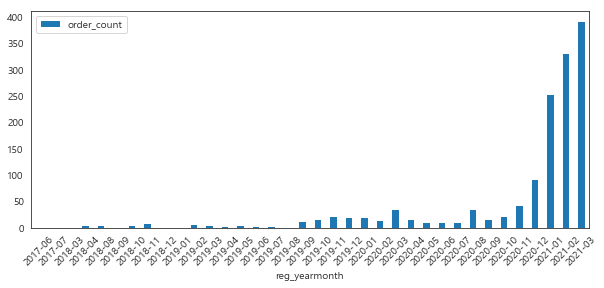

In [392]:
df_user.groupby('reg_yearmonth').sum().reset_index().plot.bar(x='reg_yearmonth', y='order_count', rot=45, figsize=(10,4))

- 가입 시기 최근 집단일수록 2021.01-03 주문량 많음

###### 자주 구매하는 카테고리 기준 코호트별

  index  sub_type
0    BA       692
1     O       267
2     D       261
3     T       164
4     B        58
5    TP        29
전체 % 
 BA    0.470428
O     0.181509
D     0.177430
T     0.111489
B     0.039429
TP    0.019714
Name: sub_type, dtype: float64


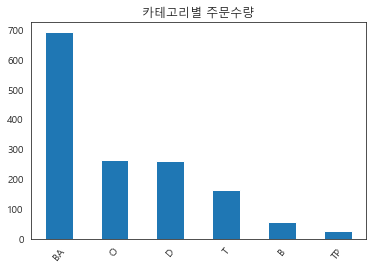

In [629]:
# 카테고리별 주문 수량
print(df.sub_type.value_counts().sort_values(ascending=False).reset_index())
print('전체 % \n',(df.sub_type.value_counts().sort_values(ascending=False)/ df.sub_type.value_counts().sum()))
df.sub_type.value_counts().sort_values(ascending=False).plot.bar(figsize=(6,4),rot=50, title='카테고리별 주문수량')

In [626]:
df.sub_type.value_counts().sum()

1471

In [420]:
df_user[['B','BA','D','O','T','TP']].describe().T

,count,mean,std,min,25%,50%,75%,max
B,1229.0,0.047193,0.295546,0.0,0.0,0.0,0.0,6.0
BA,1229.0,0.559805,0.498250,0.0,0.0,1.0,1.0,2.0
D,1229.0,0.212368,0.516481,0.0,0.0,0.0,0.0,6.0
O,1229.0,0.216436,0.431296,0.0,0.0,0.0,0.0,2.0
T,1229.0,0.133442,0.470736,0.0,0.0,0.0,0.0,8.0
TP,1229.0,0.023596,0.162221,0.0,0.0,0.0,0.0,2.0


In [424]:
# 유저가 대여시, 한번에 한 카테고리 집중된 케이스 : B, D, T 
df[df.user.isin(df_user.query('(B==6)|(D==6)|(T==8)').user.to_list())]

,brandnm,goodsnm,user,reg_date,order_date,p_type,sub_type,app_yn,reg_year,reg_month,reg_yearmonth,order_month,order_week,order_dayofweek,brandnm_luxury
151,Vivienne Westwood,basic pattern t-shirts lavender,a1142677,2021-01-13,2021-01-18,4days,T,Y,2021,01,2021-01,1,3,0,0
152,Greedilous,graphics pattern t-shirts yellow,a1142677,2021-01-13,2021-01-18,4days,T,Y,2021,01,2021-01,1,3,0,0
153,System homme,pocket stripe pattern shirts pink,a1142677,2021-01-13,2021-01-18,4days,T,Y,2021,01,2021-01,1,3,0,0
154,Covernat,button check pattern shirts mustard,a1142677,2021-01-13,2021-01-18,4days,T,Y,2021,01,2021-01,1,3,0,0
155,Musinsa standard,button basic pattern shirts deeppink,a1142677,2021-01-13,2021-01-18,4days,T,Y,2021,01,2021-01,1,3,0,0
156,Musinsa standard,button basic pattern polo-shirts beige,a1142677,2021-01-13,2021-01-18,4days,T,Y,2021,01,2021-01,1,3,0,0
157,Lafudge Store,pocket basic pattern top beige,a1142677,2021-01-13,2021-01-18,4days,T,Y,2021,01,2021-01,1,3,0,0
158,Calvin Klein,pocket basic pattern wool slacks grey,a1142677,2021-01-13,2021-01-18,4days,B,Y,2021,01,2021-01,1,3,0,0
159,Massimo Dutti,pocket basic pattern shirts mint,a1142677,2021-01-13,2021-01-18,4days,T,Y,2021,01,2021-01,1,3,0,0
1128,Alice & Olivia,see-through lace detail blouse black,a1149461,2021-03-15,2021-03-17,4days,T,NaN,2021,03,2021-03,3,11,2,0


- 가방(BA)이 압도적으로 많음 
- 유저가 대여시, 한번에 한 카테고리 집중된 케이스 : B, D, T
    - p_type 4일권
    - 가입월 = 주문월, 차이 일주일 미만 : 신규 유저 이벤트?

#### 주문 아이템 분석
- 브랜드 별 선호도, 아이템 카테고리별 선호도 분석
- 신규 유저들의 구매 트렌드 파악

##### 브랜드/카테고리별 선호도 

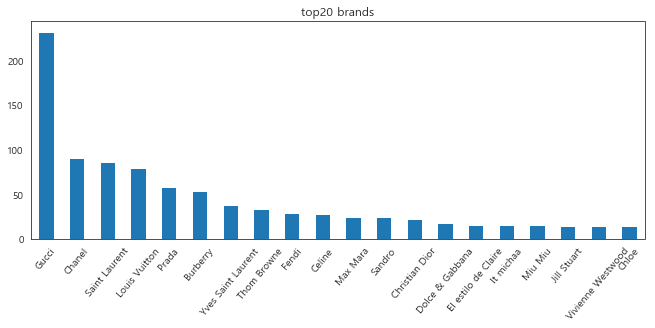

In [426]:
df.brandnm.value_counts().sort_values(ascending=False).head(20).plot.bar(figsize=(11,4),rot=50, title='top20 brands')

In [442]:
# gucci 대여 user 함께 대여한 브랜드 특별한 특징 없음 
df[df.user.isin(df.query('brandnm=="Gucci"')['user'].tolist())]['brandnm'].value_counts()

Gucci                  232
Thom Browne              2
Time homme               1
Max Mara                 1
Celine                   1
El estilo de Claire      1
Carven                   1
Burberry                 1
Dewl                     1
Yves Saint Laurent       1
Mojosphine               1
Kenzo                    1
Moncler                  1
Vivienne Westwood        1
Lenic & Mccoy            1
Heohwan Simulation       1
L’ vir                   1
Chanel                   1
Dolce & Gabbana          1
Time                     1
Givenchy                 1
Name: brandnm, dtype: int64

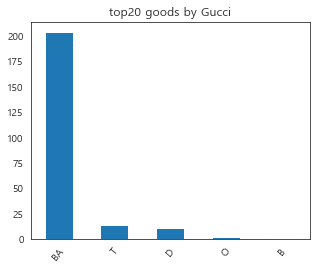

In [679]:
df.query('brandnm=="Gucci"').sub_type.value_counts().sort_values(ascending=False).head(20).plot.bar(figsize=(5,4),rot=50, title='top20 goods by Gucci')

- top 20 브랜드 대부분 명품/고가 브랜드
- 특정 브랜드 집중 : Gucci 가방

##### 신규 유저들의 구매 트렌드 파악 
- seg_new (binary) 신규유저 구분자 : 2021-01~03 가입자

In [514]:
new_list = df.query('(reg_yearmonth=="2021-01") |(reg_yearmonth=="2021-02")|(reg_yearmonth=="2021-03")').user.tolist()
df['seg_new'] = np.where(df.user.isin(new_list), 1, 0)
df.head(2)

,brandnm,goodsnm,user,reg_date,order_date,p_type,sub_type,app_yn,reg_year,reg_month,reg_yearmonth,order_month,order_week,order_dayofweek,brandnm_luxury,seg_heavy,seg_new
0,Chanel,pocket graphics pattern zipup-jumper navy,a1112031,2020-08-15,2021-01-01,7days,O,NaN,2020,08,2020-08,1,53,4,1,0,0
1,El estilo de Claire,beads stud velvet jacket black,a196681,2020-04-17,2021-01-01,4days,O,Y,2020,04,2020-04,1,53,4,0,1,0


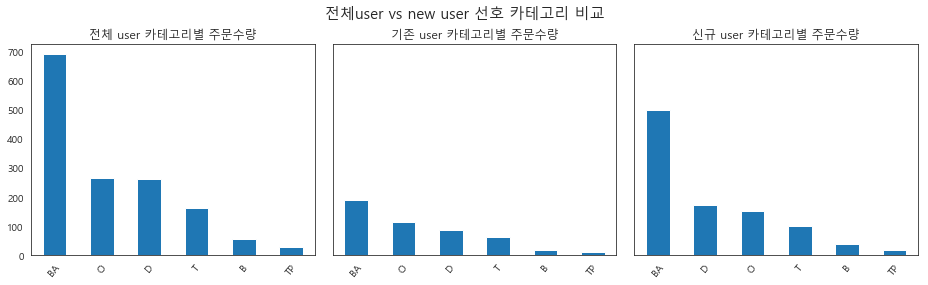

In [536]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(13,4), sharey=True)
fig.suptitle('전체user vs new user 선호 카테고리 비교', fontsize=15)
df.sub_type.value_counts().plot.bar(rot=50, title='전체 user 카테고리별 주문수량', ax=axes[0])
df.query('seg_new==0').sub_type.value_counts().plot.bar(rot=50, title='기존 user 카테고리별 주문수량', ax=axes[1])
df.query('seg_new==1').sub_type.value_counts().plot.bar(rot=50, title='신규 user 카테고리별 주문수량', ax=axes[2])

fig.tight_layout()
fig.subplots_adjust(top=0.85)

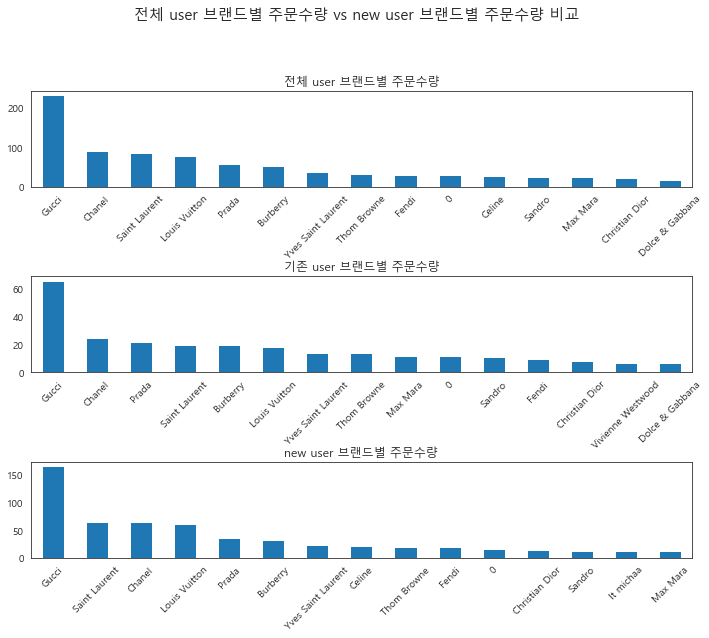

In [632]:
fig, axes = plt.subplots(nrows=3, ncols=1,figsize=(10,9))
fig.suptitle('전체 user 브랜드별 주문수량 vs new user 브랜드별 주문수량 비교', fontsize=15)
df.brandnm.value_counts().sort_values(ascending=False).head(15).plot.bar(rot=45, title='전체 user 브랜드별 주문수량', ax=axes[0])
df.query('seg_new==0').brandnm.value_counts().sort_values(ascending=False).head(15).plot.bar(rot=45, title='기존 user 브랜드별 주문수량', ax=axes[1])
df.query('seg_new==1').brandnm.value_counts().sort_values(ascending=False).head(15).plot.bar(rot=45, title='new user 브랜드별 주문수량', ax=axes[2])

fig.tight_layout()
fig.subplots_adjust(top=0.85)

Text(0.5, 1.0, '전체user vs new user 선호 카테고리 비교')

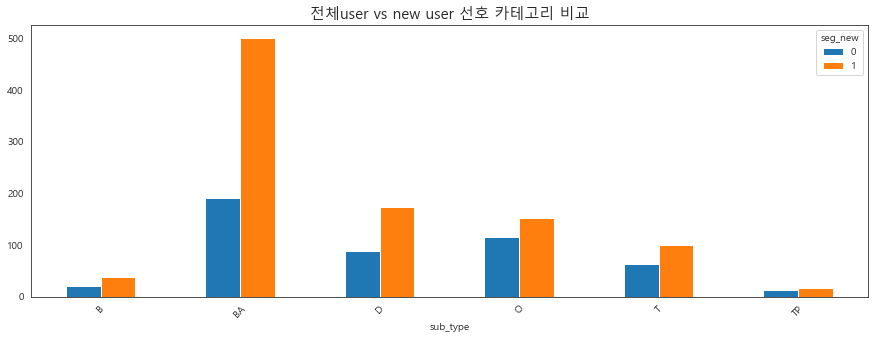

In [666]:
df.pivot_table(index='sub_type', 
               columns ='seg_new', 
               values='order_date', 
            aggfunc='count').fillna(0).plot(kind='bar', rot=45, figsize=(15,5))
plt.title('전체user vs new user 선호 카테고리 비교',fontsize=15)

- 전체 유저의 카테고리별 주문수량 vs 신규 유저 카테고리별 주문수량 트렌드 비교
    1. 전체적인 순위는 유사, BA > O or D > T > B > TB
    2. 신규 유저의 가방 수량 집중현상이 전체에 반영된 것으로 보임


- 전체 user 브랜드별 주문수량 vs 신규유저 브랜드별 주문수량 비교
    1. Gucci 집중은 유사한 형태

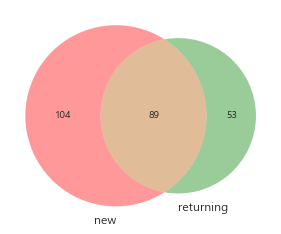

In [545]:
# 신규 유저 vs 기존 유저 주문 브랜드 차이 
plt.figure(figsize=(5,4))
venn2([set(df.query('seg_new==1')['brandnm'].tolist()),set(df.query('seg_new==0')['brandnm'].tolist())],
     set_labels = ('new','returning'))
plt.show()

**- 신규유저 vs 기존유저 브랜드 선호도 차이**
1. 신규 유저가 주문한 184개의 브랜드 중 80이 기존 유저와 중복됨 
2. 신규 유저가 주문한 184개의 브랜드 중 104(50%)이 기존 유저와 다름 > 추가로 파악해볼 필요성 있음

In [655]:
new_brand_list = list(set(df.query('seg_new==1')['brandnm'].tolist())-set(df.query('seg_new==0')['brandnm'].tolist()))

Salvatore Ferragamo    9
Mine                   7
Debb                   5
Alexander Wang         3
Studio Tomboy          3
MSGM                   3
Olive des Olive        3
Johnny Hates Jazz      3
Banana Republic        3
Sacai                  2
Name: brandnm, dtype: int64


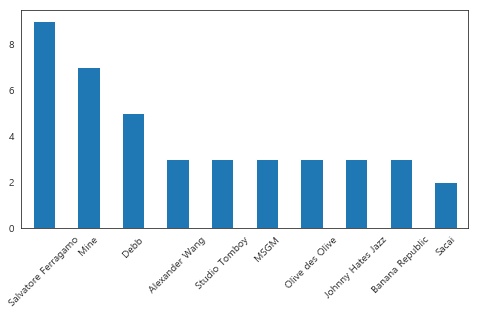

In [661]:
print(df[df.brandnm.isin(new_brand_list)].brandnm.value_counts().head(10))
df[df.brandnm.isin(new_brand_list)].brandnm.value_counts().head(10).plot.bar(rot=45, figsize=(8,4))

- Salvatore Ferragamo, Mine, Debb
- 상대적으로 덜 고가의 브랜드가 추가됨

##### heavy 유저 

In [443]:
df_user.order_count.describe().T

count    1229.000000
mean        1.192840
std         0.730499
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        11.000000
Name: order_count, dtype: float64

In [447]:
# 1건 이상 heavy user로 규정
heavy_list=df_user.query('order_count>1').user.tolist()

In [493]:
df['seg_heavy']=np.where(df.user.isin(heavy_list),1,0)

Text(0.5, 1.0, '전체user vs heavy user 가입 월 비교')

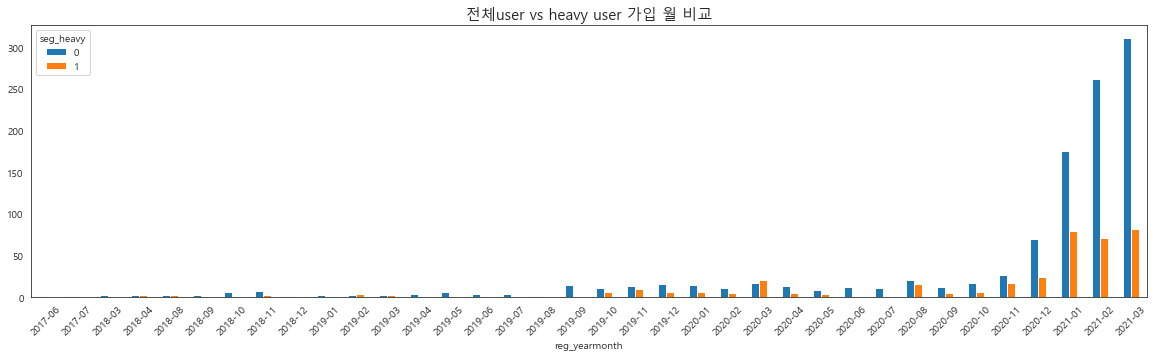

In [677]:
df.pivot_table(index='reg_yearmonth', 
               columns ='seg_heavy', 
               values='order_date', 
            aggfunc='count').fillna(0).plot(kind='bar', rot=45, figsize=(20,5))
plt.title('전체user vs heavy user 가입 월 비교',fontsize=15)

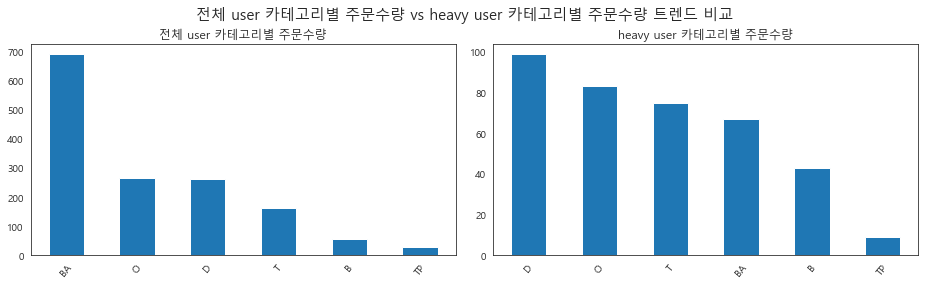

In [483]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(13,4))
fig.suptitle('전체 user 카테고리별 주문수량 vs heavy user 카테고리별 주문수량 트렌드 비교', fontsize=15)
df.sub_type.value_counts().plot.bar(rot=50, title='전체 user 카테고리별 주문수량', ax=axes[0])
df[df.user.isin(heavy_list)].sub_type.value_counts().plot.bar(rot=50, title='heavy user 카테고리별 주문수량', ax=axes[1])

fig.tight_layout()
fig.subplots_adjust(top=0.85)

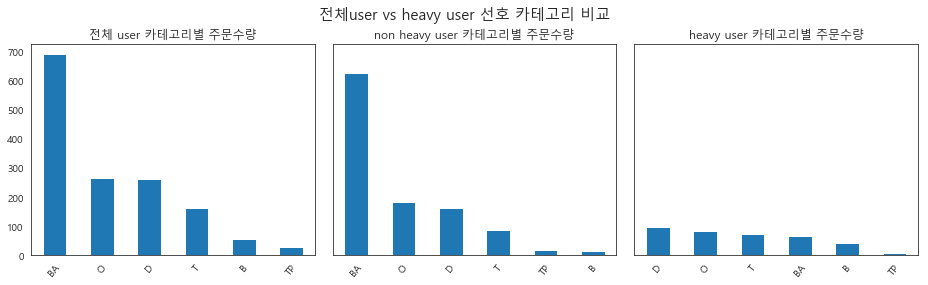

In [529]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(13,4), sharey=True)
fig.suptitle('전체user vs heavy user 선호 카테고리 비교', fontsize=15)
df.sub_type.value_counts().plot.bar(rot=50, title='전체 user 카테고리별 주문수량', ax=axes[0])
df.query('seg_heavy==0').sub_type.value_counts().plot.bar(rot=50, title='non heavy user 카테고리별 주문수량', ax=axes[1])
df.query('seg_heavy==1').sub_type.value_counts().plot.bar(rot=50, title='heavy user 카테고리별 주문수량', ax=axes[2])

fig.tight_layout()
fig.subplots_adjust(top=0.85)

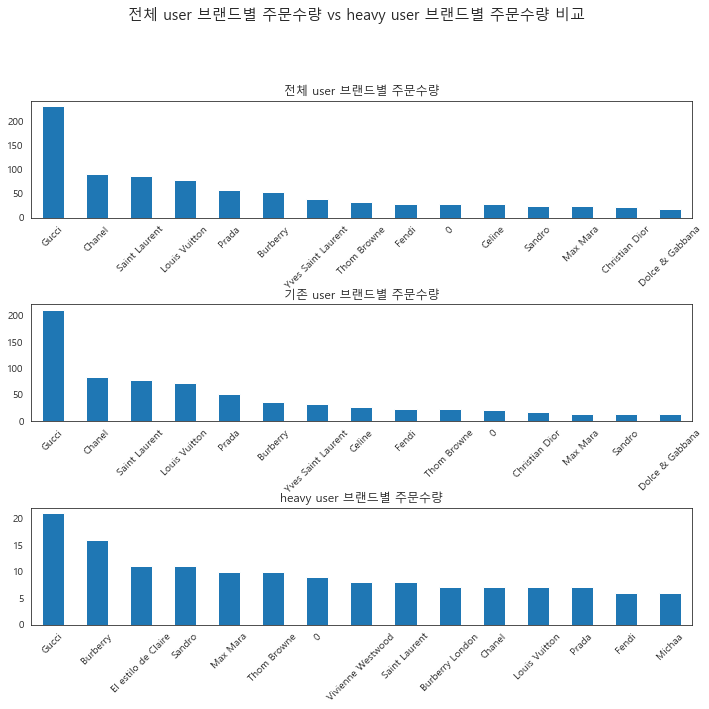

In [634]:
fig, axes = plt.subplots(nrows=3, ncols=1,figsize=(10,10))
fig.suptitle('전체 user 브랜드별 주문수량 vs heavy user 브랜드별 주문수량 비교', fontsize=15)
df.brandnm.value_counts().sort_values(ascending=False).head(15).plot.bar(rot=45, title='전체 user 브랜드별 주문수량', ax=axes[0])
df.query('seg_heavy==0').brandnm.value_counts().sort_values(ascending=False).head(15).plot.bar(rot=45, title='기존 user 브랜드별 주문수량', ax=axes[1])
df.query('seg_heavy==1').brandnm.value_counts().sort_values(ascending=False).head(15).plot.bar(rot=45, title='heavy user 브랜드별 주문수량', ax=axes[2])

fig.tight_layout()
fig.subplots_adjust(top=0.85)

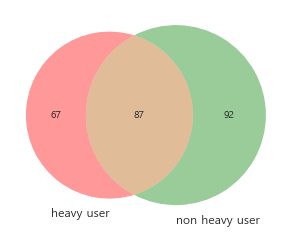

In [685]:
# 신규 유저 vs 기존 유저 주문 브랜드 차이 
plt.figure(figsize=(6,4))
venn2([set(df.query('seg_heavy==1').brandnm.value_counts().sort_values(ascending=False).index.tolist()),
       set(df.query('seg_heavy==0').brandnm.value_counts().sort_values(ascending=False).index.tolist())],
     set_labels = ('heavy user','non heavy user'))
plt.show()

- 유저 주문 건수 대부분 1 건 

**Heavy user 구분 기준 주문 수량 2건 이상**

**- 전체 유저의 카테고리별 주문수량 vs heavy user 카테고리별 주문수량 트렌드 비교**
1. 전체 유저 가방이 압도적 : 가방 >>>> 아우터 > 드레스 > 상의 >> 하의 > 투피스
2. heavy user(대여 제품 2건 이상 유저)의 경우 드레스 제일 많음 : 드레스 > 아우터 > 상의 > 가방 > 하의 >>> 투피스


**- 전체 user 브랜드별 주문수량 vs heavy user 브랜드별 주문수량 비교**
1. 브랜드 선호도에는 차이가 있음 (벤다이어그램)
2. 대부분 luxury brand
3. Gucci 집중현상 적음
4. 브랜드 정보 없는 경우 (0) 신규유저/기존유저 50% 50%

In [686]:
heavy_brand_list = list(set(df.query('seg_heavy==1')['brandnm'].tolist())-set(df.query('seg_heavy==0')['brandnm'].tolist()))
len(heavy_brand_list)

67

Amsale              3
Isabel Marant       2
Stylenanda          2
Musinsa standard    2
Versace             2
BCBG Max Azria      2
C.holyn             2
Cesare Paciotti     2
Convexo Concave     2
Since then          2
Name: brandnm, dtype: int64


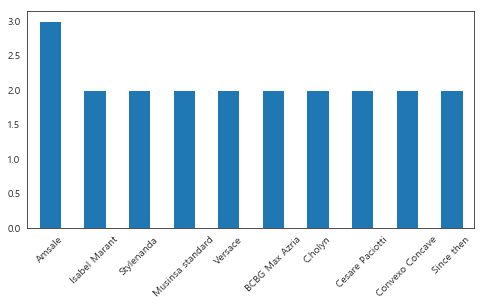

In [689]:
print(df[df.brandnm.isin(heavy_brand_list)].brandnm.value_counts().sort_values(ascending=False).head(10))
df[df.brandnm.isin(heavy_brand_list)].brandnm.value_counts().sort_values(ascending=False).head(10).plot.bar(rot=45, figsize=(8,4))

- 높은 건수는 아님
- 고가의 브랜드는 아님

#### 인기 브랜드 분석

1. 집단 구분
    - 신규 유저 vs 기존 유저
    - 헤비 유저 vs non 헤비 유저
    

2. 상기 집단 구분에서 top 15 (주문수량기준) 내 브랜드 추출 후 중복되는 브랜드 : popular_brand_list 집중 분석
    - 명품 브랜드

In [698]:
s1 = set(df.query('seg_new==1').brandnm.value_counts().sort_values(ascending=False).head(15).index.tolist())
s2 = set(df.query('seg_new==0').brandnm.value_counts().sort_values(ascending=False).head(15).index.tolist())
s3 = set(df.query('seg_heavy==1').brandnm.value_counts().sort_values(ascending=False).head(15).index.tolist())
s4 = set(df.query('seg_heavy==0').brandnm.value_counts().sort_values(ascending=False).head(15).index.tolist())
popular_brand_list = list(s1&s2&s3&s4)
len(list(s1&s2&s3&s4))

11

In [703]:
#popular_brand_list.remove("0")
popular_brand_list

['Max Mara',
 'Chanel',
 'Thom Browne',
 'Gucci',
 'Saint Laurent',
 'Prada',
 'Louis Vuitton',
 'Burberry',
 'Fendi',
 'Sandro']

In [704]:
df[df.brandnm.isin(popular_brand_list)]

,brandnm,goodsnm,user,reg_date,order_date,p_type,sub_type,app_yn,reg_year,reg_month,reg_yearmonth,order_month,order_week,order_dayofweek,brandnm_luxury,seg_heavy,seg_new
0,Chanel,pocket graphics pattern zipup-jumper navy,a1112031,2020-08-15,2021-01-01,7days,O,NaN,2020,08,2020-08,1,53,4,1,0,0
6,Gucci,marmont gg logo quilted bag Black 4,a1127774,2020-10-30,2021-01-03,7days,BA,Y,2020,10,2020-10,1,53,6,0,0,0
7,Gucci,sylvie mini chain ribbon bag white,a1138262,2020-12-19,2021-01-03,4days,BA,Y,2020,12,2020-12,1,53,6,0,0,0
11,Max Mara,lace detail crop cardigan black_1,a1119528,2020-09-14,2021-01-04,4days,T,Y,2020,09,2020-09,1,1,0,0,1,0
13,Burberry,belt basic pattern trench-coat red,a1119528,2020-09-14,2021-01-04,4days,O,Y,2020,09,2020-09,1,1,0,1,1,0
14,Sandro,button stripe pattern shirts skyblue,a1140958,2021-01-03,2021-01-04,4days,T,NaN,2021,01,2021-01,1,1,0,0,0,1
15,Prada,padding two way bag black,a1141018,2021-01-04,2021-01-04,4days,BA,Y,2021,01,2021-01,1,1,0,1,0,1
21,Gucci,mixed pattern ribbon jacket multi,a1137159,2020-12-15,2021-01-05,7days,T,Y,2020,12,2020-12,1,1,1,0,0,0
22,Saint Laurent,quilted calfskin shoulder bag,a1139320,2020-12-22,2021-01-05,7days,BA,Y,2020,12,2020-12,1,1,1,1,1,0
25,Gucci,mixed pattern knit top multi,a1139436,2020-12-23,2021-01-05,4days,T,Y,2020,12,2020-12,1,1,1,0,0,0


#### 연관분석
- http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/
- https://wotres.tistory.com/entry/Association-Rule-%EC%97%B0%EA%B4%80%EC%84%B1-%EB%B6%84%EC%84%9D-in-python
- 지지도 해석 : x, y가 함께 발생할 확률 

###### 연관분석 모듈 / function

In [549]:
# 연관규칙
def toList(x):
    return list(set(x))

In [611]:
# 인코딩/연관분석 모듈 import
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

##### 브랜드  
- 지지도 0.2보다 낮아서 사용 X

In [584]:
df['brandnm'] = df['brandnm'].fillna("0")

In [613]:
# 같이 구매한 브랜드 리스트
# 2개 이상 필터링
df_asso=df.groupby('user').brandnm.apply(lambda x : toList(x)).reset_index()
df_asso['len'] = df_asso.brandnm.apply(lambda x: len(x)>=2)
df_asso.head(5)

,user,brandnm,len
0,a1100548,"[Yves Saint Laurent, On&On]",True
1,a1100887,[Gucci],False
2,a1101514,[Max Mara],False
3,a1101645,[Gucci],False
4,a1102068,[Gucci],False


In [614]:
asso_list = list(df_asso.brandnm)

In [587]:
asso_list[:10]

[['Yves Saint Laurent', 'On&On'],
 ['Max Mara', 'Chanel'],
 ['& Other Stories', 'Fendi'],
 ['Andersson Bell', 'Cesare Paciotti'],
 ['Sandro', 'Fendi'],
 ['Thom Browne', 'Burberry'],
 ['Jigott', 'Diane von Furstenberg'],
 ['Prada', 'Louis Vuitton'],
 ['Dint', 'On&On'],
 ['El estilo de Claire', 'Margarin fingers']]

In [595]:
#! pip install mlxtend
# 인코딩용
from mlxtend.preprocessing import TransactionEncoder
# 연관분석 
from mlxtend.frequent_patterns import apriori
te=TransactionEncoder() # 객체 생성

In [615]:
asso_list_encoded = te.fit(asso_list).transform(asso_list)
# one hot encoding
asso_list_encoded=asso_list_encoded.astype("int")
df_asso_encoded = pd.DataFrame(asso_list_encoded, columns=te.columns_)

In [616]:
df_asso_encoded.columns

Index(['& Other Stories', '0', 'A BY A', 'A.P.C.', 'ACNE STUDIOS', 'Adidas',
       'Adidas X Stella Mccartney', 'Akro', 'Alexander Mcqueen',
       'Alexander Wang',
       ...
       'Wai Kei', 'Wonder Style', 'Your Name Here', 'Yves Saint Laurent',
       'Zadig & Voltaire', 'Zooc', 'cecilie bahnsen', 'khrisjoy', 'roajeu',
       'thom browne'],
      dtype='object', length=246)

In [617]:
df_asso_encoded.head(5)

,& Other Stories,0,A BY A,A.P.C.,ACNE STUDIOS,Adidas,Adidas X Stella Mccartney,Akro,Alexander Mcqueen,Alexander Wang,...,Wai Kei,Wonder Style,Your Name Here,Yves Saint Laurent,Zadig & Voltaire,Zooc,cecilie bahnsen,khrisjoy,roajeu,thom browne
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [618]:
apriori(df_asso_encoded, min_support=0.2, use_colnames=True)

,support,itemsets


##### 카테고리 
**- 가방과 아우터 카테고리 간 지지도, 신뢰도, 향상도 높은 편이나, 전체 주문 수량의 50% 정도이기 때문인 것 같음**

In [620]:
# 같이 구매한 브랜드 리스트
# 2개 이상 필터링
df_asso2=df.groupby('user').sub_type.apply(lambda x : toList(x)).reset_index()
df_asso2['len'] = df_asso2.sub_type.apply(lambda x: len(x)>=2)
asso_list2 = list(df_asso2.query('len==True').sub_type)

# 객체 생성
te=TransactionEncoder() 

# Encoding 
asso_list_encoded2 = te.fit(asso_list2).transform(asso_list2)
# 0,1 로 변환
asso_list_encoded2=asso_list_encoded2.astype("int")
df_asso_encoded2 = pd.DataFrame(asso_list_encoded2, columns=te.columns_)

# df_asso_encoded.columns
df_asso_encoded2.head(5)

,B,BA,D,O,T,TP
0,1,1,0,0,0,0
1,0,1,0,1,0,0
2,0,1,1,0,0,0
3,0,1,1,0,0,0
4,0,1,0,1,0,0


In [622]:
apriori(df_asso_encoded2, min_support=0.2, use_colnames=True)

,support,itemsets
0,0.259259,(B)
1,0.611111,(BA)
2,0.333333,(D)
3,0.648148,(O)
4,0.370370,(T)
5,0.388889,"(BA, O)"


In [624]:
df_frequent_itemsets= apriori(df_asso_encoded2, min_support=0.2, use_colnames=True)
df_frequent_itemsets['len']=df_frequent_itemsets['itemsets'].apply(lambda x : len(x))
df_frequent_itemsets[df_frequent_itemsets['len']>=2]

,support,itemsets,len
5,0.388889,"(BA, O)",2


In [625]:
association_rules(df_frequent_itemsets, metric='lift')

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(BA),(O),0.611111,0.648148,0.388889,0.636364,0.981818,-0.007202,0.967593
1,(O),(BA),0.648148,0.611111,0.388889,0.600000,0.981818,-0.007202,0.972222


**- 가방과 아우터 카테고리 간 지지도, 신뢰도, 향상도 높은 편이나, 전체 주문 수량의 50% 정도이기 때문인 것 같음**